Anomaly Detection for Image Data
https://github.com/sarehsoltani/Image-Anomaly-Detection-on-MvTec-dataset/blob/master/MvTec_demo.ipynb

In [ ]:
!pip uninstall anomalib

Found existing installation: anomalib 1.2.0.dev0
Uninstalling anomalib-1.2.0.dev0:
  Would remove:
    /usr/local/bin/anomalib
    /usr/local/lib/python3.10/dist-packages/__editable__.anomalib-1.2.0.dev0.pth
    /usr/local/lib/python3.10/dist-packages/anomalib-1.2.0.dev0.dist-info/*
Proceed (Y/n)? Y
  Successfully uninstalled anomalib-1.2.0.dev0


In [ ]:
# Install Anomalib via PyPI

!git clone https://github.com/openvinotoolkit/anomalib.git
%cd anomalib
%pip install -v .

fatal: destination path 'anomalib' already exists and is not an empty directory.
/content/anomalib
Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Processing /content/anomalib
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-b8pymmrq
  Entered build tracker: /tmp/pip-build-tracker-b8pymmrq
  Created temporary directory: /tmp/pip-install-ugccd_9m
  Created temporary directory: /tmp/pip-ephem-wheel-cache-rbr2jnpu
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, 

In [ ]:
# Verify anomalib installation

import anomalib
anomalib.__version__

'1.2.0dev'

In [ ]:
# Check Python path

import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython']

In [ ]:
# Change PATH to working directory on Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
PATH = "/content/anomalib/"

**Models**
Currently, there are 13 anomaly detection models avaliable in anomalib. Namely,

*   CFA
*   PADIM
*   CFlow
*   DFKDE
*   DFM
*   DRAEM
*   EfficentAd
*   FastFlow
*   GANomaly
*   PatchCore
*   Reverse Distillation
*   STFPM

In this tutrial, we will be using Padim
PaDiM: A Patch Distribution Modeling Framework for Anomaly Detection
* Patch-based algorithm relying on pre-trained CNN feature extractor.
* Breaks image into patches, extracts embeddings using different layers.
* Concatenates activation vectors for diverse semantic levels.
* Encodes fine-grained and global contexts in embeddings.
* Reduces dimensions of embedding vectors to mitigate redundancy.
* Generates multivariate Gaussian distribution for each patch embedding.
* Distribution calculated across entire training batch.
* Inference uses Mahalanobis distance to score test image patches.
* Uses inverse of covariance matrix from training for Mahalanobis distance.
* Anomaly map formed from Mahalanobis distance scores.
* Higher scores in anomaly map indicate anomalous regions.


**OpenVINO** is a toolkit developed by Intel for optimizing and deploying deep learning inference (using models for predictions). It is often used to accelerate inference on Intel hardware.

**wandb** stands for "Weights & Biases," and it's a tool for experiment tracking, dataset versioning, and model management for machine learning projects.

**pytorch_lightning** is a high-level framework built on top of PyTorch that simplifies the process of training and developing deep learning models. It handles much of the boilerplate code associated with training, allowing you to focus on the core research aspects.


**Python Imaging Library**
PIL is a fundamental library in Python for image manipulation. It provides a wide range of functionalities for opening, manipulating, and saving various image file formats. Although PIL is the original library, it's actually Pillow that is actively maintained and widely used today. Pillow is a fork of PIL and acts as its modern replacement.

In [ ]:
!pip install OpenVINO


In [ ]:
! pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-lightning

In [1]:
# Import libraries
import os
from pathlib import Path
from typing import Any
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage
from __future__ import annotations

from anomalib.data import get_datamodule
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import get_model

/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
from anomalib.configs import get_config
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

ModuleNotFoundError: No module named 'anomalib.pre_processing'

Here's a breakdown of each package being installed:

**defusedxml**: This package helps to prevent vulnerabilities when processing XML data, making it safer to handle external XML files.
**requests**: This is a popular library used for making HTTP requests. It is commonly used to interact with web services and APIs.
**networkx**: This library is used for creating, manipulating, and studying the structure, dynamics, and functions of complex networks.
**nncf**: This stands for "Neural Network Compression Framework." It's a toolkit from Intel for optimizing and compressing deep learning models.
**openvino-dev**: This is the development package for OpenVINO, which is used to optimize and deploy deep learning inference. The -dev suffix indicates that it's the development version, which may include additional tools and resources for developers.
**onnx**: ONNX stands for "Open Neural Network Exchange." It's a format for representing deep learning models that allows models to be transferred between different frameworks and tools.

In [ ]:
! pip install defusedxml requests networkx nncf openvino-dev onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.7 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3


**Configuration**

Training a model on aspecific dataset reqquires further configuration, Each model has its own configuration file, named config.yaml. It contains dta, model and training configurable paramters.

Next, I use the Padim model. Now, let's get its config path from the respected folder and take a quick look at it

In [ ]:
CONFIG_PATH = PATH+"/configs/model/padim.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

model:
  class_path: anomalib.models.Padim
  init_args:
    layers:
      - layer1
      - layer2
      - layer3
    backbone: resnet18
    pre_trained: true
    n_features: null

metrics:
  pixel: AUROC



In [2]:
config = get_config(config_path=CONFIG_PATH)

NameError: name 'get_config' is not defined

Set up Dataset: MVTec AD

We could import the MVTec AD dataset using its specific datamodule implemented in anomalib

In [3]:
from anomalib.data import MVTec

In [4]:
datamodule = MVTec(num_workers=0)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.
i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

mvtec: 5.26GB [02:58, 29.5MB/s]                            


dict_keys(['image_path', 'label', 'image', 'mask'])


In [22]:
datamodule.root

PosixPath('datasets/MVTec')

Check the shapes of the input images amd masks

In [5]:
print(data["image"].shape, data["mask"].shape)

torch.Size([32, 3, 900, 900]) torch.Size([32, 900, 900])


Visualize a normal and abnormal sample from the validation set.

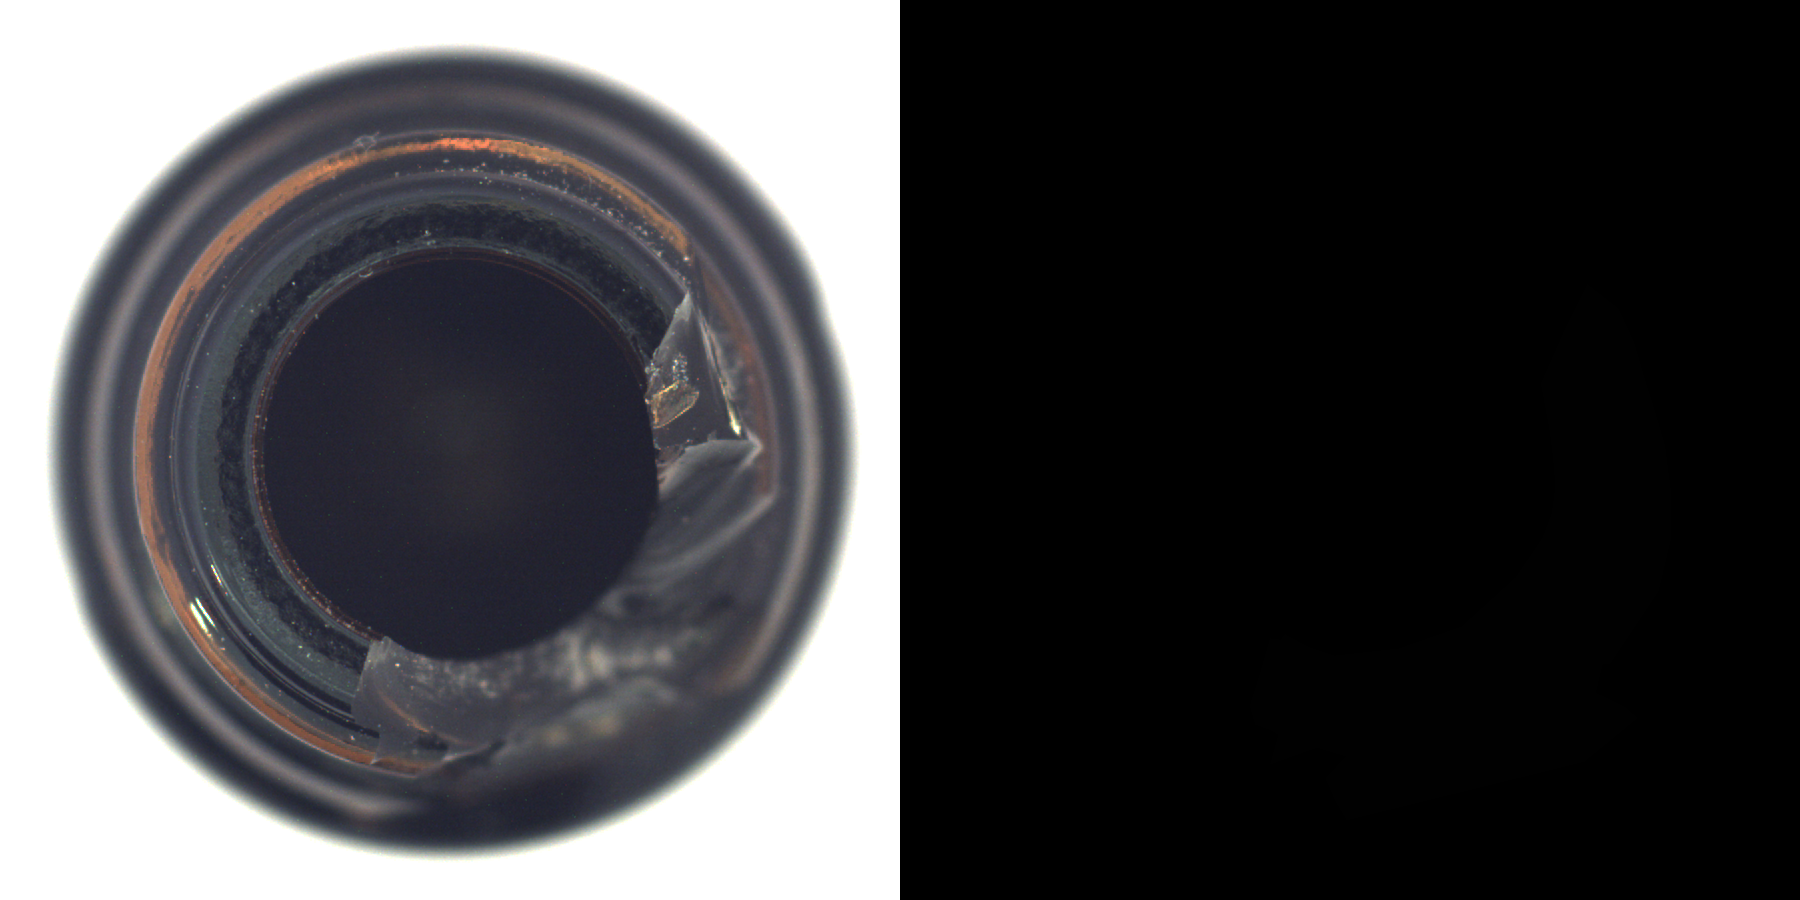

In [6]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    """Show an image with a mask.

    Args:
        sample (dict[str, Any]): Sample from the dataset.
        index (int): Index of the sample.

    Returns:
        Image: Output image with a mask.
    """
    # Load the image from the path
    image = Image.open(sample["image_path"][index])

    # Load the mask and convert it to RGB
    mask = ToPILImage()(sample["mask"][index]).convert("RGB")

    # Resize mask to match image size, if they differ
    if image.size != mask.size:
        mask = mask.resize(image.size)

    return Image.fromarray(np.hstack((np.array(image), np.array(mask))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

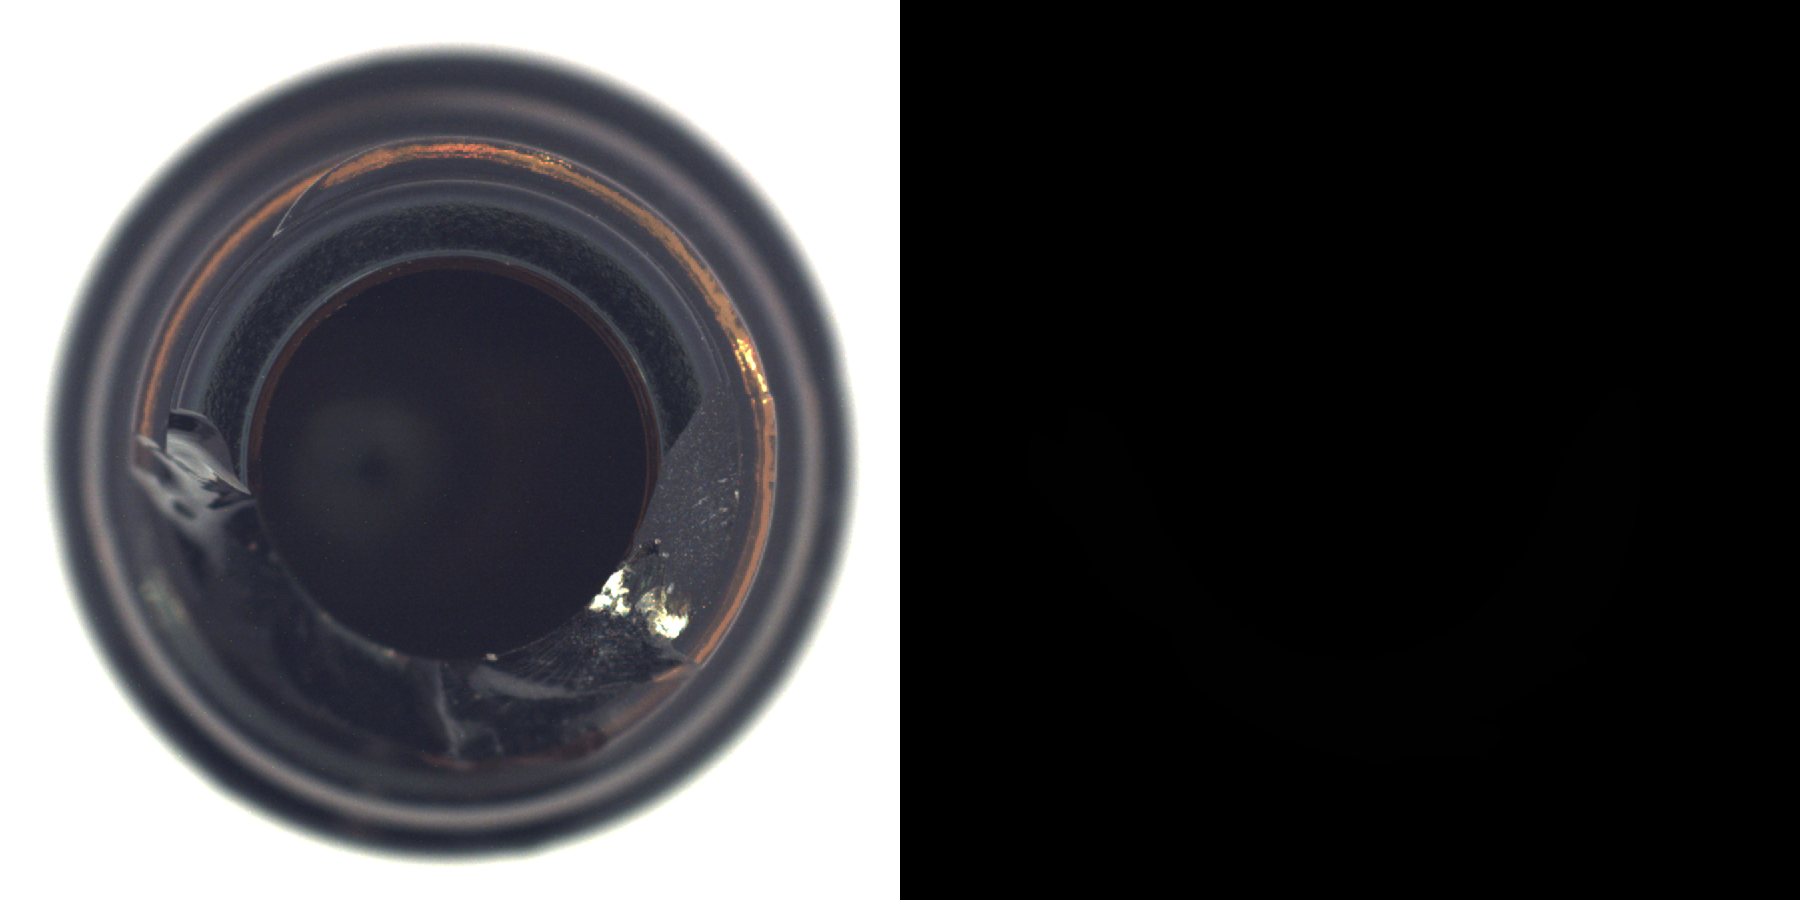

In [40]:
show_image_and_mask(data, index=1)

**Prepare Model**

Create the Padim and train it




In [7]:
from anomalib.engine import Engine
from anomalib.models import Padim

In [8]:
# Get the model and datamodule
model = Padim()
datamodule = MVTec(num_workers=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [10]:
from anomalib import TaskType

In [11]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PadimModel    

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


**Validation**

In [13]:
# Load best model from checkpoint before evaluating
test_result = engine.test(model=model,
                          datamodule=datamodule,
                          ckpt_path=engine.trainer.checkpoint_callback.best_model_path)

/usr/local/lib/python3.10/dist-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=model.de

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │    0.9919999837875366     │
│        pixel_AUROC        │    0.9821542501449585     │
│       pixel_F1Score       │     0.713831901550293     │
└───────────────────────────┴───────────────────────────┘


> **OpenVINO Inference**
Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.

Before we can use the OpenVINO inference, let's export the model to OpenVINO format first



In [15]:
from anomalib.deploy import ExportType, OpenVINOInferencer


In [17]:
engine.export(model=model,
              export_type=ExportType.OPENVINO)

/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/jit_utils.py:314: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:739: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:1244: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_typ

PosixPath('/content/results/Padim/MVTec/bottle/latest/weights/openvino/model.xml')

Load a test image

In [32]:
image_path = "/content/datasets/MVTec/bottle/test/broken_large/000.png"
image = read_image(path="./datasets/MVTec/bottle/test/broken_large/000.png")
plt.imshow(image)

Load the OpenVINO Model

By default, the output files are saved into results directory. Let's check where the OpenVINO model is stored

In [27]:
output_path = Path(engine.trainer.default_root_dir)
output_path

PosixPath('/content/results/Padim/MVTec/bottle/latest')

In [28]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
metadata = output_path / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata.exists())

True True


In [29]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

Perform Inference

Predicting an image using OpenVINO inferencer is as simple as calling predict method.

In [34]:
predictions = inferencer.predict(image=image_path)

Visualizing Inference Results

In [50]:
print(predictions.pred_score, predictions.pred_label)

0.7307917125838796 LabelName.ABNORMAL


In [46]:
%matplotlib inline

In [51]:
# Visualize the original image
plt.imshow(predictions.image)

In [45]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)
plt.show()

In [44]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

In [48]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

In [49]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)